## Prétraitement

In [9]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, get_simplified_names
from src.experiments_bruit_val import (
    prepare_data_random_split, train_xgboost_models
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


### Scenario : All Features + Nom Encoded

In [10]:
from sklearn.preprocessing import StandardScaler
from src.bruit_val import add_noise_after_split
# Scenario 3: All features + encoded categorical
X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)
X_train_cat, X_test_cat = encode_categorical_feature(
    X_train_cat, X_test_cat, data, "Nom"
)

# Standardisation
scaler = StandardScaler()
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)

# Ajout du bruit
X_train_cat_noisy, X_test_cat_noisy = add_noise_after_split(
    X_train_cat_scaled,
    X_test_cat_scaled,
    noise_std=1,
    random_state=42,
    noise_on="both"
)

# Retour à l’échelle originale
X_train_cat_final = scaler.inverse_transform(X_train_cat_noisy)
X_test_cat_final = scaler.inverse_transform(X_test_cat_noisy)

# Entraînement sur données en unités physiques
results_cat_all, metrics_cat_all, models_cat_all, ypred_cat_all = train_xgboost_models(
    X_train_cat_final, X_test_cat_final, y_train_cat, y_test_cat,
    vars_cibles, simplified_names, random_state=42, ypred=True
)

print("\nScenario : All Chemical + NOM Composition Variables")
print(f"Train size: {len(X_train_cat)}, Test size: {len(X_test_cat)}")
print(f"R² variance weighted: {metrics_cat_all['R2_variance_weighted']:.4f}")
print(f"R² uniform: {metrics_cat_all['R2_uniform']:.4f}")
print(f"R² min: {metrics_cat_all['R2_min']:.4f}")
print("\nDetailed results:")
print(results_cat_all.to_string(index=False))



Scenario : All Chemical + NOM Composition Variables
Train size: 5100, Test size: 1276
R² variance weighted: 0.6536
R² uniform: 0.6283
R² min: 0.5383

Detailed results:
Variable cible    MAE   RMSE     R2
            EB 273.71 366.47 0.6557
       ED porc 373.52 494.32 0.6594
       EM porc 363.66 484.68 0.6458
       EN porc 293.77 390.08 0.7016
      EMAn coq 376.99 484.88 0.6381
   EMAn poulet 369.44 473.03 0.6337
           UFL   0.13   0.18 0.6280
           UFV   0.15   0.20 0.6329
          PDIA  33.02  52.85 0.5935
           PDI  32.72  52.52 0.5841
      BalProRu  49.64  65.76 0.5383


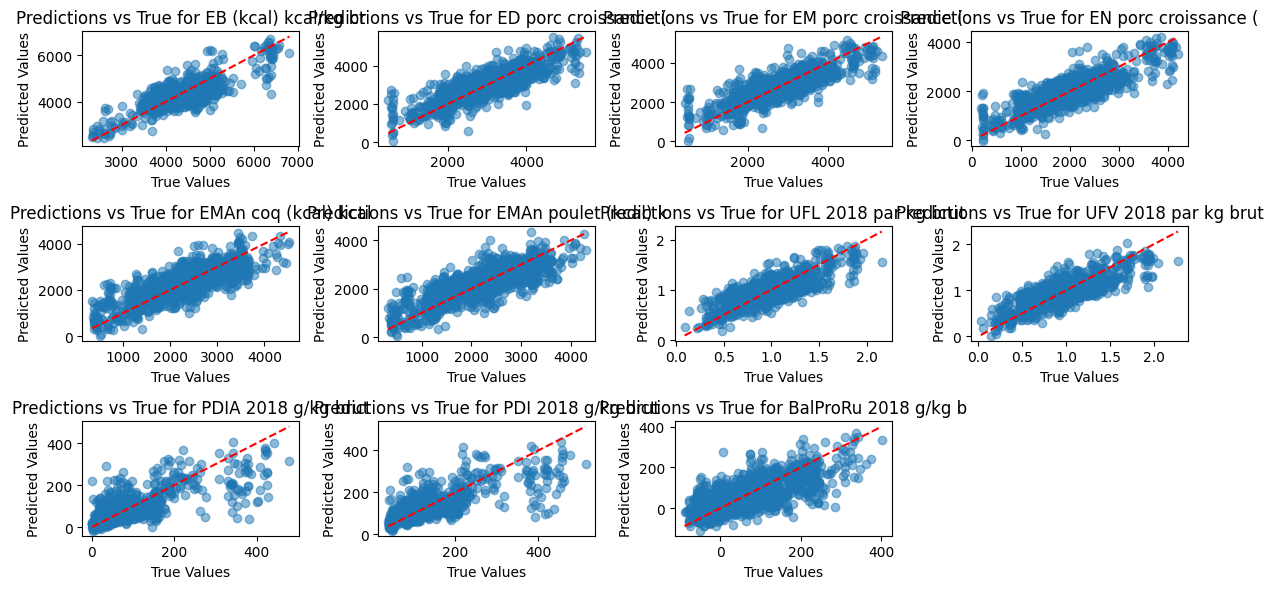

In [11]:
from src.plot_deep import plot_real_vs_pred
y_test_all2 = y_test_cat.values

plot_real_vs_pred(y_test_all2, ypred_cat_all, vars_cibles)

In [17]:
import numpy as np

l_std = np.arange(0, 1.05, 0.05)
R2=[[] for k in range(0,3)]
l_var= ['train','test','both']
i=0

X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)
X_train_cat, X_test_cat = encode_categorical_feature(
    X_train_cat, X_test_cat, data, "Nom"
)

# Standardisation
scaler = StandardScaler()
X_train_cat_scaled = scaler.fit_transform(X_train_cat)
X_test_cat_scaled = scaler.transform(X_test_cat)


for var in l_var:
    for k in range(len(l_std)):
        noise=l_std[k]

        # Ajout du bruit
        X_train_cat_noisy, X_test_cat_noisy = add_noise_after_split(
            X_train_cat_scaled,
            X_test_cat_scaled,
            noise_std=noise,
            random_state=42,
            noise_on=var
        )

        # Retour à l’échelle originale
        X_train_cat_final = scaler.inverse_transform(X_train_cat_noisy)
        X_test_cat_final = scaler.inverse_transform(X_test_cat_noisy)

        # Entraînement sur données en unités physiques
        results_cat_all, metrics_cat_all, models_cat_all, ypred_cat_all = train_xgboost_models(
            X_train_cat_final, X_test_cat_final, y_train_cat, y_test_cat,
            vars_cibles, simplified_names, random_state=42, ypred=True
        )
        R2[i].append(metrics_cat_all['R2_uniform'])
    i+=1
print(R2)


[[0.9918, 0.9897, 0.9877, 0.9831, 0.978, 0.9732, 0.9661, 0.9612, 0.9536, 0.9469, 0.9404, 0.9289, 0.9194, 0.9076, 0.9019, 0.8933, 0.8837, 0.8711, 0.8602, 0.8515, 0.831], [0.9918, 0.9553, 0.9297, 0.9079, 0.8826, 0.8562, 0.831, 0.8042, 0.78, 0.7483, 0.7202, 0.6881, 0.658, 0.6233, 0.5922, 0.56, 0.5292, 0.4952, 0.4631, 0.4268, 0.3929], [0.9918, 0.9861, 0.9792, 0.9682, 0.9567, 0.9464, 0.9269, 0.91, 0.8921, 0.8753, 0.8511, 0.8322, 0.8072, 0.7887, 0.7653, 0.7449, 0.7243, 0.7001, 0.6725, 0.652, 0.6283]]


In [19]:
print(len(R2))
print(len(R2[0]))
print(len(l_std))

3
21
21


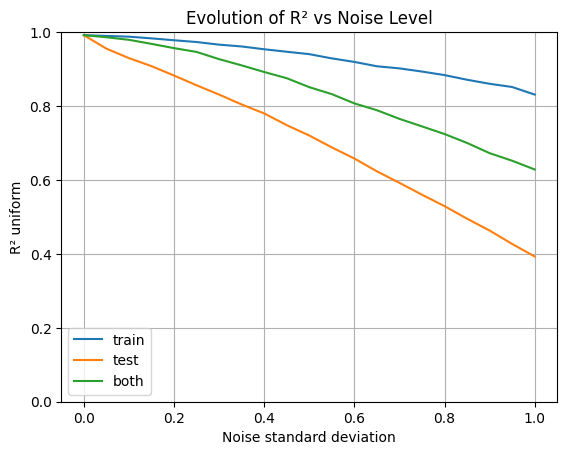

In [20]:
import matplotlib.pyplot as plt

plt.figure()

for i, label in enumerate(l_var):
    plt.plot(l_std, R2[i], label=label)

plt.xlabel("Noise standard deviation")
plt.ylabel("R² uniform")
plt.title("Evolution of R² vs Noise Level")
plt.legend()
plt.ylim((0,1))
plt.grid(True)

plt.show()

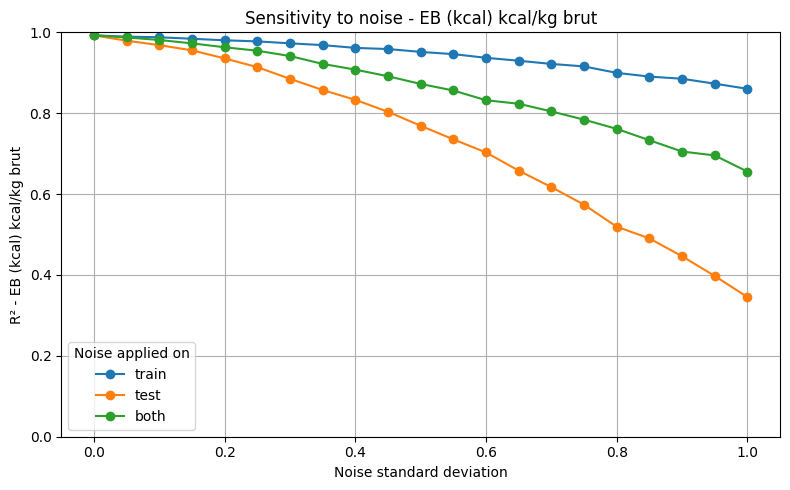

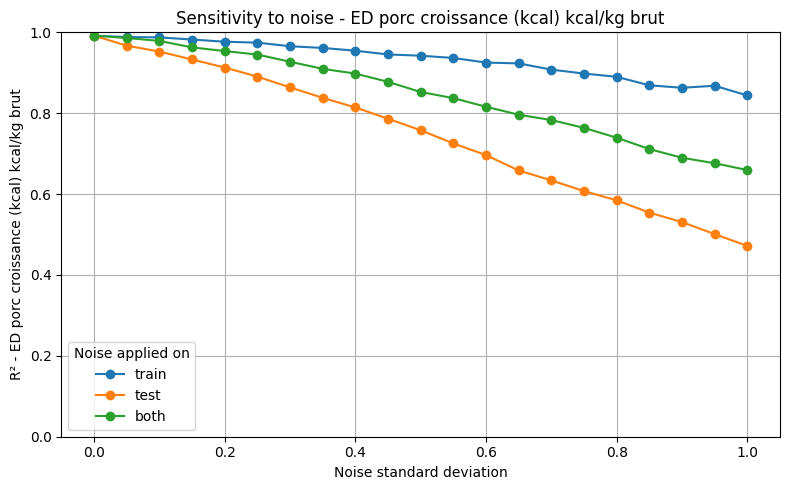

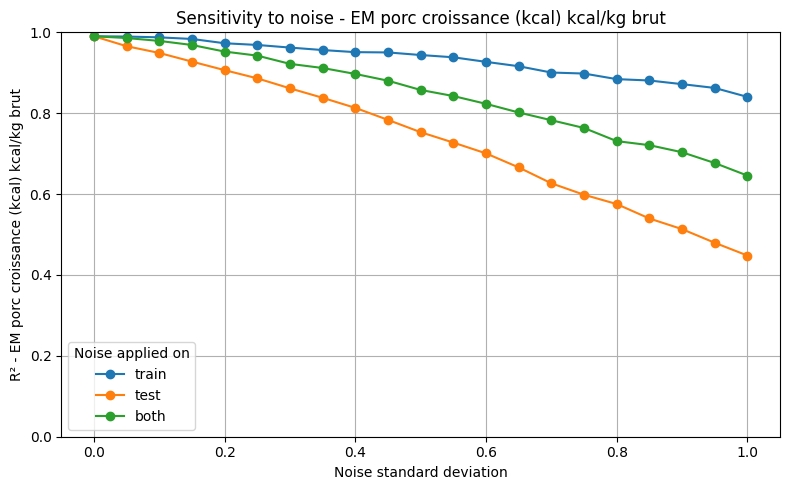

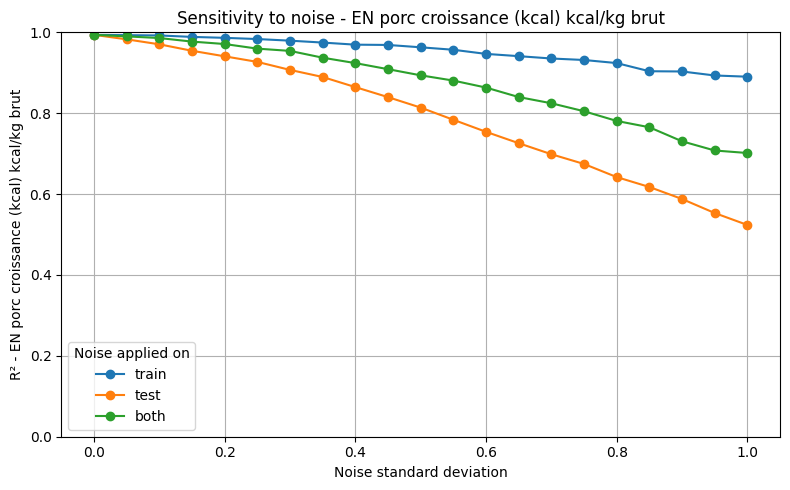

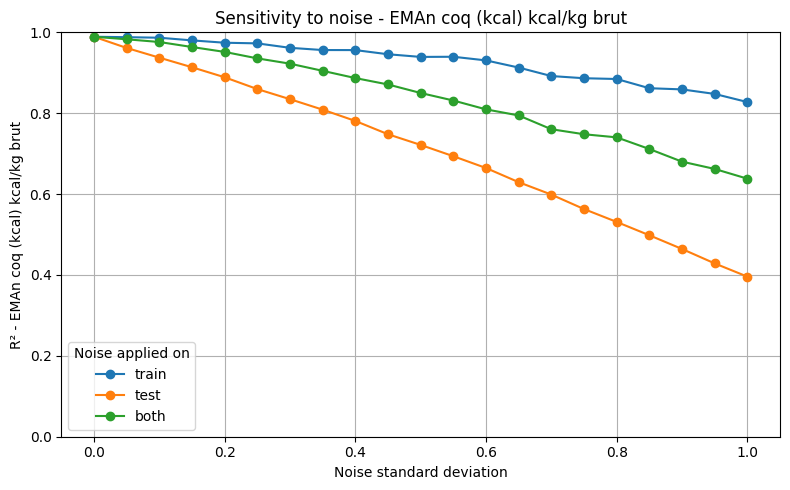

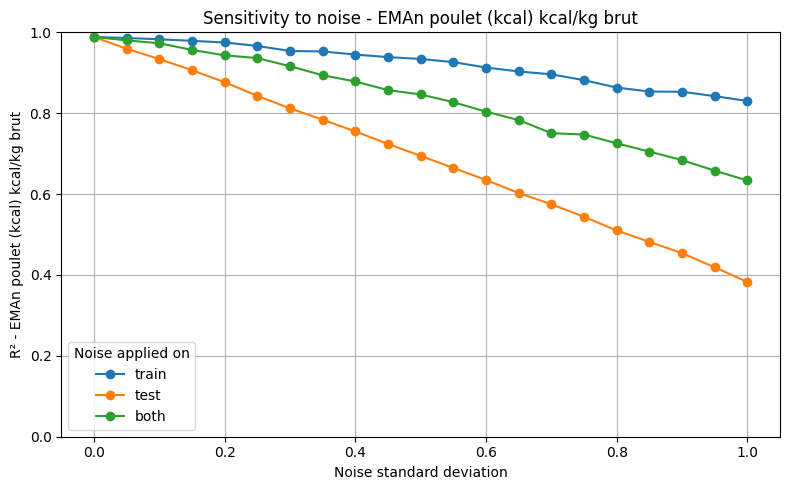

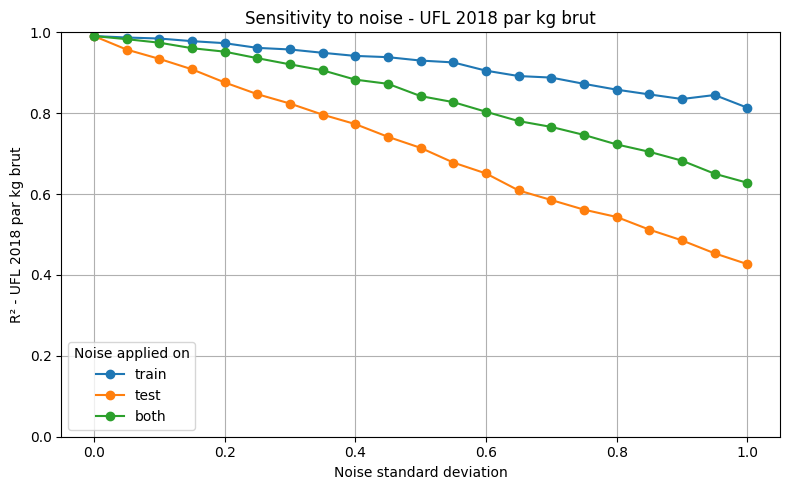

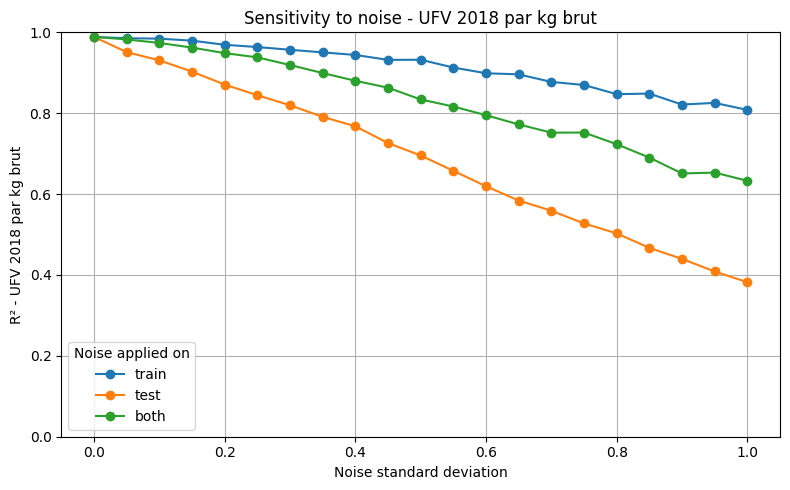

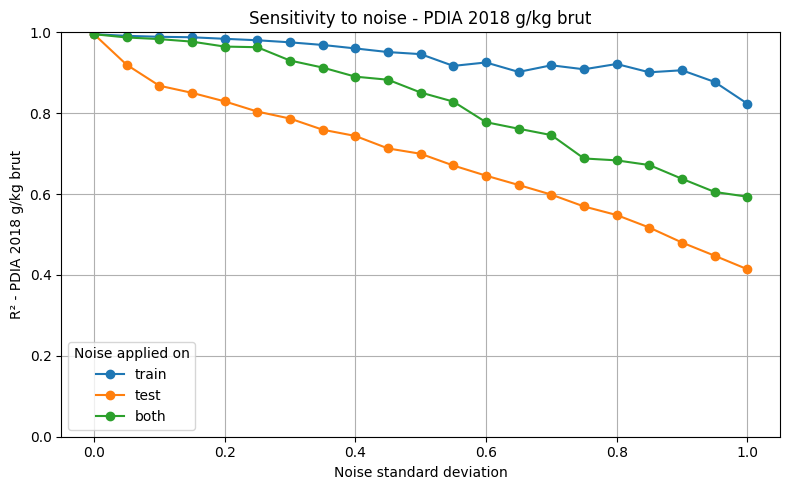

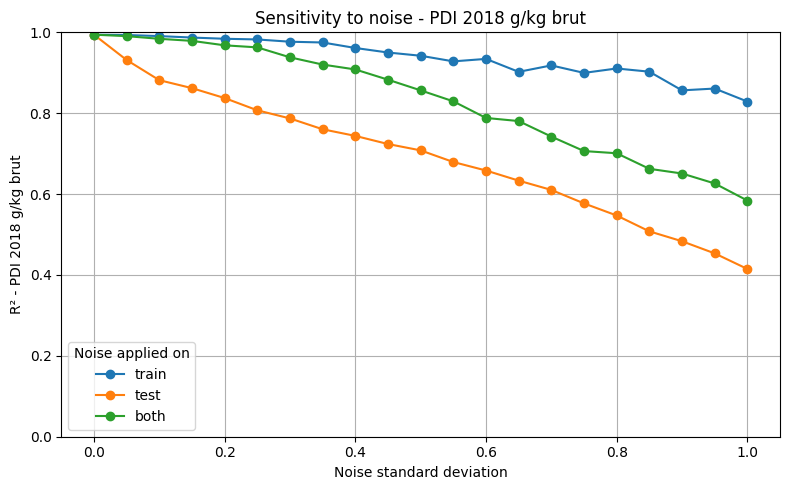

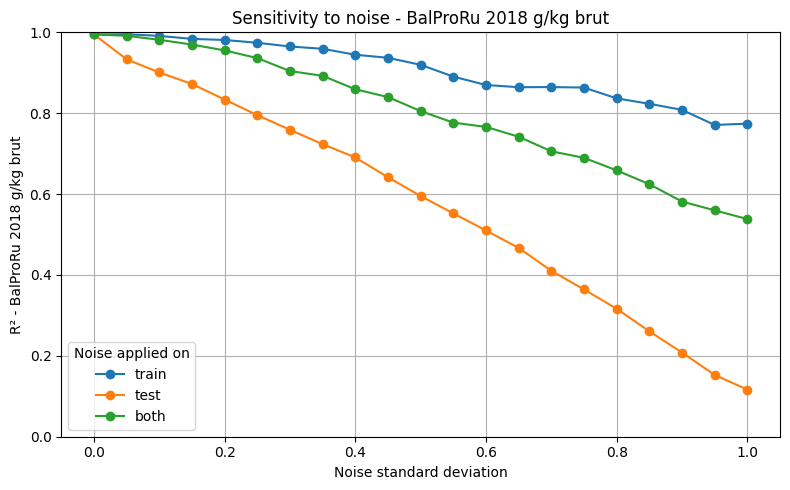

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Paramètres
# -----------------------------
l_std = np.arange(0, 1.05, 0.05)
l_var = ['train', 'test', 'both']
n_cases = len(l_var)

# -----------------------------
#Split une seule fois
# -----------------------------
X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Encodage
X_train_cat, X_test_cat = encode_categorical_feature(
    X_train_cat, X_test_cat, data, "Nom"
)

# -----------------------------
# Standardisation une seule fois
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cat)
X_test_scaled = scaler.transform(X_test_cat)

# -----------------------------
# Initialisation stockage
# -----------------------------
n_outputs = len(vars_cibles)

# Structure : R2[case][output][noise_level]
R2_2 = [[[] for _ in range(n_outputs)] for _ in range(n_cases)]

# -----------------------------
# Boucle sur scénarios + bruit
# -----------------------------
for i, var in enumerate(l_var):

    for noise in l_std:

        # Ajout bruit
        X_train_noisy, X_test_noisy = add_noise_after_split(
            X_train_scaled,
            X_test_scaled,
            noise_std=noise,
            random_state=42,
            noise_on=var
        )

        # Retour échelle originale
        X_train_final = scaler.inverse_transform(X_train_noisy)
        X_test_final = scaler.inverse_transform(X_test_noisy)

        # Entraînement
        results_cat_all, metrics_cat_all, models_cat_all, ypred_cat_all = train_xgboost_models(
            X_train_final, X_test_final, y_train_cat, y_test_cat,
            vars_cibles, simplified_names, random_state=42, ypred=True
        )

        # Stockage R2 individuel
        for j in range(n_outputs):
            R2_2[i][j].append(results_cat_all.loc[j, "R2"])

# -----------------------------
# Tracé : un graphe par sortie
# -----------------------------
for j in range(n_outputs):

    plt.figure(figsize=(8,5))

    for i, label in enumerate(l_var):
        plt.plot(l_std, R2_2[i][j], marker='o', label=label)

    plt.xlabel("Noise standard deviation")
    plt.ylabel(f"R² - {vars_cibles[j]}")
    plt.title(f"Sensitivity to noise - {vars_cibles[j]}")
    plt.legend(title="Noise applied on")
    plt.grid(True)
    plt.tight_layout()
    plt.ylim((0,1))
    plt.show()

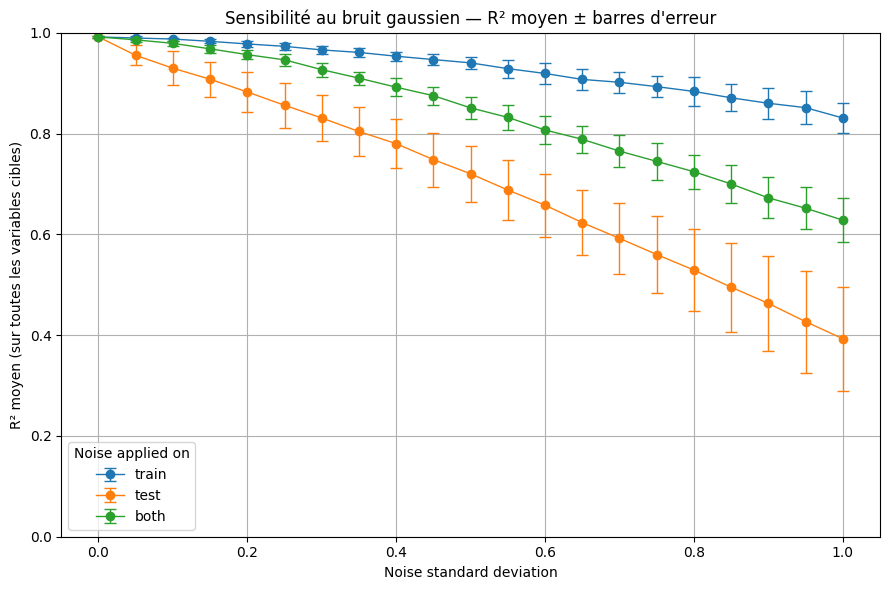

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Convertit R2_2 en array: shape = (n_cases, n_outputs, n_noise_levels)
R2_arr = np.array(R2_2, dtype=float)

# Moyenne et barres d'erreurs sur les sorties (axes outputs)
mean_r2 = R2_arr.mean(axis=1)               # (n_cases, n_noise)
std_r2  = R2_arr.std(axis=1, ddof=1)        # (n_cases, n_noise)

# Option: erreur standard de la moyenne (SEM) au lieu de l'écart-type
sem_r2 = std_r2 / np.sqrt(R2_arr.shape[1])  # (n_cases, n_noise)

# Choisis ici la barre d'erreur que tu veux afficher:
yerr = std_r2      # <-- écart-type
# yerr = sem_r2    # <-- ou SEM

# Plot combiné
plt.figure(figsize=(9, 6))

for i, label in enumerate(l_var):
    plt.errorbar(
        l_std,
        mean_r2[i],
        yerr=yerr[i],
        marker="o",
        capsize=4,
        linewidth=1,
        label=label
    )

plt.xlabel("Noise standard deviation")
plt.ylabel("R² moyen (sur toutes les variables cibles)")
plt.title("Sensibilité au bruit gaussien — R² moyen ± barres d'erreur")
plt.ylim((0, 1))
plt.grid(True)
plt.legend(title="Noise applied on")
plt.tight_layout()
plt.show()